In [60]:
import random
import numpy as np
import random
import gymnasium as gym
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from tqdm import tqdm

In [61]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode="ansi")

env.reset()

#Current State
print(env.unwrapped.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.observation_space.n)
#int state== ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal,_, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state, _ = env.reset()
print(state, 'state')
print ("Decoded state:", list(env.unwrapped.decode(state)))


473
Number of states: 500
Number of actions that an agent can take: 6
Action taken: west
Transition probability: {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 1, 0], dtype=int8)}
Next state: 473
Reward recieved: -1
Terminal state: False
133 state
Decoded state: [1, 1, 3, 1]


In [62]:
seed= 1
def egreedy_policy(q_values,xy,epsilon):
    if random.random()>epsilon and q_values[xy].any():
        
        action=np.argmax(q_values[xy])
    else:
        action = random.randint(0, q_values.shape[-1]-1)

    return action

goal= {0:[0,0], 1:[0,4], 2:[4,0], 3:[4,3]}

In [63]:
#IOQL Learning
gamma = 0.9
alpha= 0.65

num_options= 4
q_IOQL= np.zeros((500, 4))
updatefreq_IOQL= np.zeros((500, 4))
Qopt= {i:np.zeros((25,6)) for i in range(num_options)}

eps_decay= 0.99
eps_main= 0.5
eps_min= 0.01

eps= [0.01, 0.01, 0.01, 0.01]
IOQL_rew= []
IOQL_avg=[]
IOQL_avg_history=[]
for i in tqdm(range(5000)):
    state,_= env.reset()
    done= False
    total_reward= 0
    
    while not done:
        option_chosen= egreedy_policy(q_IOQL, state, eps_main)
  
        eps_main= max(eps_min, eps_decay*eps_main)
        optdone= False
        s= state
        reward_bar =0

        
        while optdone == False:
            x,y,pas,drop= env.unwrapped.decode(state)
            if x== goal[option_chosen][0] and y== goal[option_chosen][1]:
                
            
                optdone= True
                if pas == option_chosen:
                  
                    optact= 4
                elif drop == option_chosen :
                 
                    optact= 5
                else:
                    optact = 1 if (option_chosen in [0,1]) else 0
            else:
                optdone= False
                optact= egreedy_policy(Qopt[option_chosen], 5*x + y, eps[option_chosen])
                eps[option_chosen]= max(eps_min, eps_decay* eps[option_chosen])
                
            next_state, reward, done1,done2, _= env.step(optact)
            

            done= done1 + done2
            reward_bar= gamma*reward_bar + reward
            total_reward = total_reward + reward
           
            
            if optact < 6:
                x_next, y_next, _, _ = env.unwrapped.decode(next_state)
            
                Qopt[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt[option_chosen][5*x_next + y_next]) - Qopt[option_chosen][5*x + y, optact]))

            for opt in range(num_options):
                x,y,pas,drop= env.unwrapped.decode(state)
                if x== goal[opt][0] and y== goal[opt][1]:
                    
                
                    optdone_opt= True
                    if pas == opt:
                    
                        optact_opt= 4
                    elif drop == opt :
                    
                        optact_opt= 5
                    else:
                        optact_opt = 1 if (opt in [0,1]) else 0
                        
                else:
                    optdone_opt = False
                    optact_opt = egreedy_policy(Qopt[opt], 5*x + y, eps[opt])
                    eps[opt]= max(eps_min, eps_decay* eps[opt])
                    
                if optact_opt == optact:
                    eps[opt] = max(eps_min,eps_decay*eps[opt])
                    if optdone_opt:
                        q_IOQL[state, opt] += alpha*(reward + gamma*np.max(q_IOQL[next_state,:]) - q_IOQL[state, opt])
                    else:
                        q_IOQL[state, opt] += alpha*(reward + gamma*q_IOQL[next_state, opt] - q_IOQL[state, opt]) 

                    updatefreq_IOQL[state, opt] += 1
                    
               
            state = next_state
            
        if done == True:
            break
        
    IOQL_rew.append(total_reward)
    IOQL_avg= np.mean(IOQL_rew[-100:])
    IOQL_avg_history.append(IOQL_avg)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:06<00:00, 815.99it/s] 


In [64]:
# SMDP learning
gamma = 0.9

alpha= 0.1

num_options= 4
q_SMDP= np.zeros((500, 4))
updatefreq_SMDP= np.zeros((500, 4))
Qopt= {i:np.zeros((25,6)) for i in range(num_options)}

eps_decay= 0.99
eps_main= 0.5
eps_min= 0.01

eps= [0.01, 0.01, 0.01, 0.01]
SMDP_rew = []
SMDP_avg= []
SMDP_avg_history=[]
for i in tqdm(range(10000)):
    state,_= env.reset()
    done= False
    total_reward= 0
    
    while not done:
        option_chosen= egreedy_policy(q_SMDP, state, eps_main)
  
        eps_main= max(eps_min, eps_decay*eps_main)
        optdone= False
        s= state
        reward_bar =0
        k=0
        
        while optdone == False:
            x,y,pas,drop= env.unwrapped.decode(state)
            if x== goal[option_chosen][0] and y== goal[option_chosen][1]:
                
            
                optdone= True
                if pas == option_chosen:
                  
                    optact= 4
                elif drop == option_chosen :
                 
                    optact= 5
                else:
                    optact = 1 if (option_chosen in [0,1]) else 0
            else:
                optdone= False
                optact= egreedy_policy(Qopt[option_chosen], 5*x + y, eps[option_chosen])
                eps[option_chosen]= max(eps_min, eps_decay* eps[option_chosen])
                
            next_state, reward, done1, done2,_= env.step(optact)#
            done= done1 + done2

            
            reward_bar= gamma*reward_bar + reward
            k+=1
            total_reward = total_reward + reward
            
            
            if optact < 6:
                x_next, y_next, _, _ = env.unwrapped.decode(next_state)
            
                Qopt[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt[option_chosen][5*x_next + y_next]) - Qopt[option_chosen][5*x + y, optact]))
               
               
            state= next_state
            
        q_SMDP[s][option_chosen] += alpha*(reward_bar + (gamma**k)*(np.max(q_SMDP[state])- q_SMDP[s][option_chosen]))
        updatefreq_SMDP[s][option_chosen] += 1
     
        
        if done == True:
            break
        
    SMDP_rew.append(total_reward)
    SMDP_avg= np.mean(SMDP_rew[-100:])
    SMDP_avg_history.append(SMDP_avg)

100%|██████████| 10000/10000 [00:12<00:00, 802.38it/s]


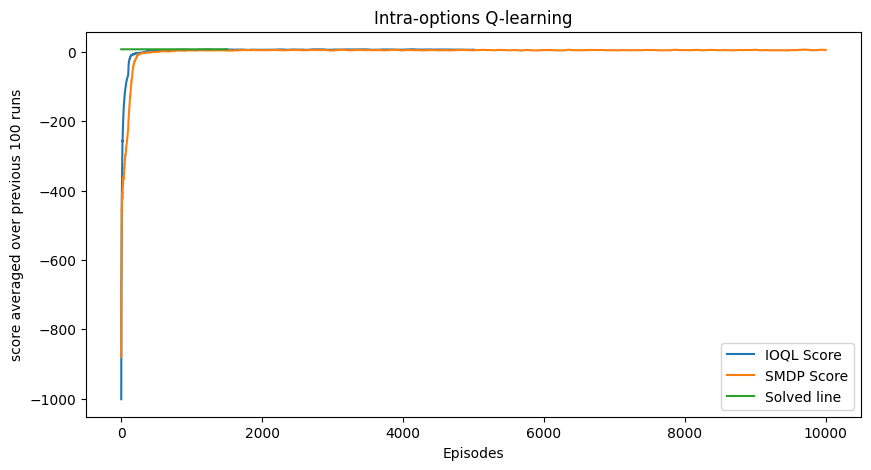

In [65]:
plt.figure(figsize = (10,5))
avg_rews2 = [np.average(IOQL_rew[i:i+100]) for i in range(1400)]
plt.plot(IOQL_avg_history,label = 'IOQL Score')
avg_rews3 = [np.average(SMDP_rew[i:i+100]) for i in range(1400)]
plt.plot(SMDP_avg_history,label = 'SMDP Score')
plt.plot([8 for i in range(1500)],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Intra-options Q-learning')
plt.legend()

New options with HRL- Options to go to pick and drop locations

In [68]:
def subgoal(env, state, opt):
    option_chosen= opt
    optdone= False
    k=0
    reward_bar =0
    total_reward=0
    while optdone == False:
            x,y,pas,drop= env.unwrapped.decode(state)
            goal=[pas, drop] ##if reach dynamically alloted goals, pick or drop
            if x== goal[option_chosen][0] and y== goal[option_chosen][1]:
        
                optdone= True
                if pas == option_chosen:
                  
                    optact= 4
                elif drop == option_chosen :
                 
                    optact= 5
                else:
                    optact = 1 if (option_chosen in [0,1]) else 0
            else:
                optdone= False
                optact= egreedy_policy(Qopt[option_chosen], 5*x + y, eps[option_chosen])
                eps[option_chosen]= max(eps_min, eps_decay* eps[option_chosen])
                
            next_state, reward, done1, done2, _= env.step(optact)

            done= done1 + done2
            reward_bar= gamma*reward_bar + reward
            k+=1
            total_reward = total_reward + reward
            
            if optact < 4:
                x_next, y_next, _, _ = env.unwrapped.decode(next_state)
            
                Qopt[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt[option_chosen][5*x_next + y_next]) - Qopt[option_chosen][5*x + y, optact]))
               
              
            state= next_state
    if option_chosen==pas and optdone==True: ##check if passenger is picked or not
        picked= True
    else:
        picked= False

    return [reward_bar, k, state, total_reward, done, picked]
    
    

In [69]:
gamma = 0.9
alpha= 0.1

num_options= 2 #options are to pick and drop
# passenger_npos=5; drop_npos= 4
q_SMDP= np.zeros((500, num_options))
updatefreq_SMDP= np.zeros((500, num_options))
Qopt= {i:np.zeros((25,4)) for i in range(num_options)}

eps_decay= 0.99
eps_main= 0.5
eps_min= 0.01

eps= [0.01, 0.01, 0.01, 0.01]

picked= False

SMDP_rew_2= []
SMDP_sub_history=[]
for i in tqdm(range(5000)):
    state, _ = env.reset()
    done= False
    total_reward= 0
    prev= 0
    
    while not done:
        x,y,pas,drop= env.unwrapped.decode(state)
        # opt= prev
        s= state
        goal=[pas, drop]
        
        ##choose from e greedy of SMDP policy learnt to choose from the alloted options
        opt= egreedy_policy(q_SMDP, state, eps_main) 
        eps_main= max(eps_min, eps_decay* eps_main)
        if pas ==4 or picked==True:
            opt=drop
      
        
        
        [reward_bar, k, state, total_reward, done, picked]= subgoal(env, state, opt)
            
        q_SMDP[s][opt] += alpha*(reward_bar + (gamma**k)*(np.max(q_SMDP[state])- q_SMDP[s][opt]))
        updatefreq_SMDP[s][opt] += 1
      
      
        
        if done == True:
            break
        
    SMDP_rew_2.append(total_reward)
    SMDP_avg= np.mean(SMDP_rew_2[-100:])
    SMDP_sub_history.append(SMDP_avg)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:04<00:00, 1060.43it/s]


In [70]:
def subgoal_IOQL(env, state, opt):
    option_chosen= opt
    optdone= False
    k=0
    reward_bar =0
    total_reward=0
    while optdone == False:
            x,y,pas,drop= env.unwrapped.decode(state)
            goal=[pas, drop]
            if x== goal[option_chosen][0] and y== goal[option_chosen][1]:
                
                
                optdone= True
                if pas == option_chosen:
                  
                    optact= 4
                elif drop == option_chosen :
                 
                    optact= 5
                else:
                    optact = 1 if (option_chosen in [0,1]) else 0
            else:
                optdone= False
                optact= egreedy_policy(Qopt[option_chosen], 5*x + y, eps[option_chosen])
                eps[option_chosen]= max(eps_min, eps_decay* eps[option_chosen])
                
            next_state, reward, done1, done2, _= env.step(optact)

            done= done1 + done2
            reward_bar= gamma*reward_bar + reward
            k+=1
            total_reward = total_reward + reward
            
            if optact < 4:
                x_next, y_next, _, _ = env.unwrapped.decode(next_state)
            
                Qopt[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt[option_chosen][5*x_next + y_next]) - Qopt[option_chosen][5*x + y, optact]))
                
            for opt in range(num_options):## IOQL update of other options with the same action
                    x,y,pas,drop= env.unwrapped.decode(state)
                    if x== goal[opt][0] and y== goal[opt][1]: #if reached destinations, pick/drop
                        
                    
                        optdone_opt= True
                        if pas == opt:
                        
                            optact_opt= 4
                        elif drop == opt :
                        
                            optact_opt= 5
                        else:
                            optact_opt = 1 if (opt in [0,1]) else 0
                            #stay in the same place if reached goal, but isnt pick/drop location
                    else: #keep moving e-greedily till reach the goal
                        optdone_opt = False
                        optact_opt = egreedy_policy(Qopt[opt], 5*x + y, eps[opt])
                        eps[opt]= max(eps_min, eps_decay* eps[opt])
                        
                    if optact_opt == optact: #if same action chosen in a different option, update the option for that state-action combination
                        eps[opt] = max(eps_min,eps_decay*eps[opt])
                        u = ((1-optdone)*q_IOQL[next_state, opt]) + (optdone*np.max(q_IOQL[next_state,:]))
                        q_IOQL[state, opt] += alpha*(reward + gamma*u - q_IOQL[state, opt])
                        updatefreq_IOQL[state, opt] += 1
               
              
            state= next_state
    if option_chosen==pas and optdone==True:
        picked= True
    else:
        picked=False

    return [reward_bar, k, state, total_reward, done, picked]
    
    

In [71]:
gamma = 0.9
alpha= 0.1

num_options= 2
# passenger_npos=5; drop_npos= 4
q_IOQL= np.zeros((500, num_options))
updatefreq_SMDP= np.zeros((500, num_options))
Qopt= {i:np.zeros((25,4)) for i in range(num_options)}

eps_decay= 0.99
eps_main= 0.5
eps_min= 0.01

eps= [0.01, 0.01, 0.01, 0.01]

picked= False

IOQL_rew_2= []
IOQL_sub_history=[]
for i in tqdm(range(5000)):
    state, _ = env.reset()
    done= False
    total_reward= 0
    prev= 0
    
    while not done:
        x,y,pas,drop= env.unwrapped.decode(state)
        
        s= state
        
        
        goal=[pas, drop]
        opt= egreedy_policy(q_IOQL, state, eps_main) #choosing between zero and one
        eps_main= max(eps_min, eps_decay* eps_main)
        if pas ==4 or picked==True:
            opt=drop
      
        
        
        [reward_bar, k, state, total_reward, done, picked]= subgoal(env, state, opt)
            
        # q_IOQL[s][opt] += alpha*(reward_bar + (gamma**k)*(np.max(q_IOQL[state])- q_IOQL[s][opt]))
        # updatefreq_SMDP[s][opt] += 1
      
      
        
        if done == True:
            break
        
    IOQL_rew_2.append(total_reward)
    SMDP_avg= np.mean(IOQL_rew_2[-100:])
    IOQL_sub_history.append(SMDP_avg)

 27%|██▋       | 1341/5000 [00:02<00:03, 1040.39it/s]

100%|██████████| 5000/5000 [00:04<00:00, 1096.23it/s]


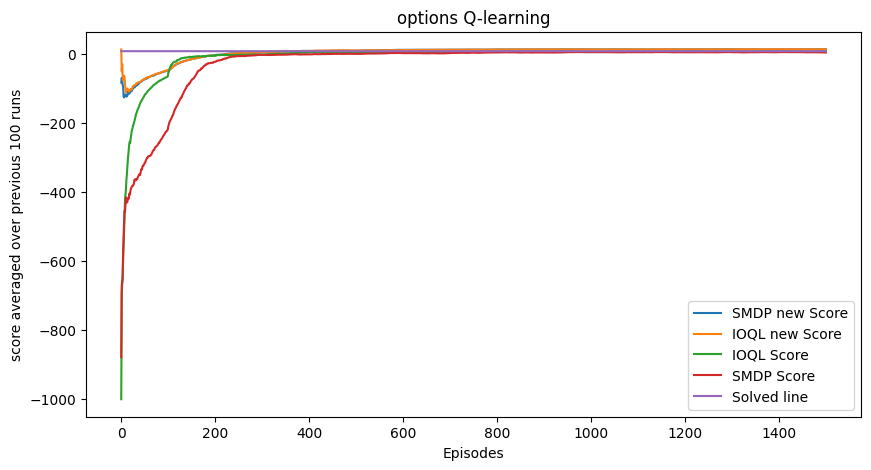

In [72]:
plt.figure(figsize = (10,5))

plt.plot(SMDP_sub_history[:1500],label = 'SMDP new Score')
plt.plot(IOQL_sub_history[:1500],label = 'IOQL new Score')
plt.plot(IOQL_avg_history[:1500],label = 'IOQL Score')
plt.plot(SMDP_avg_history[:1500],label = 'SMDP Score')
plt.plot([8 for i in range(1500)],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('options Q-learning')
plt.legend()

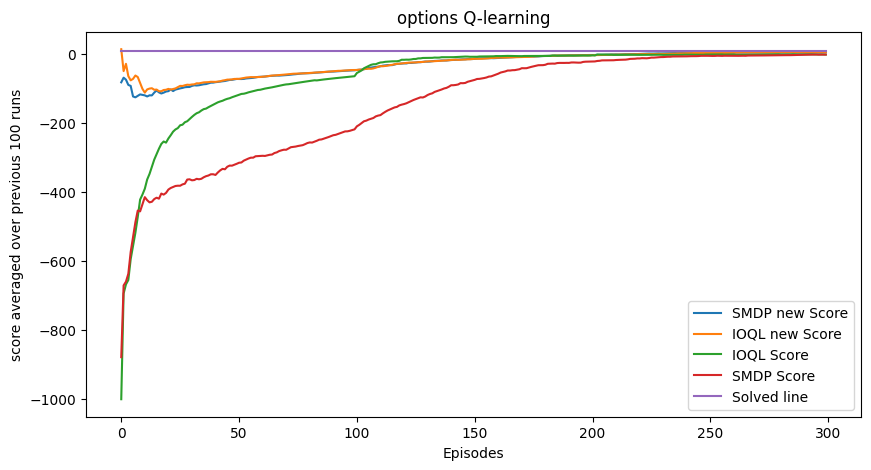

In [73]:
plt.figure(figsize = (10,5))

plt.plot(SMDP_sub_history[:300],label = 'SMDP new Score')
plt.plot(IOQL_sub_history[:300],label = 'IOQL new Score')
plt.plot(IOQL_avg_history[:300],label = 'IOQL Score')
plt.plot(SMDP_avg_history[:300],label = 'SMDP Score')
plt.plot([8 for i in range(300)],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('options Q-learning')
plt.legend()

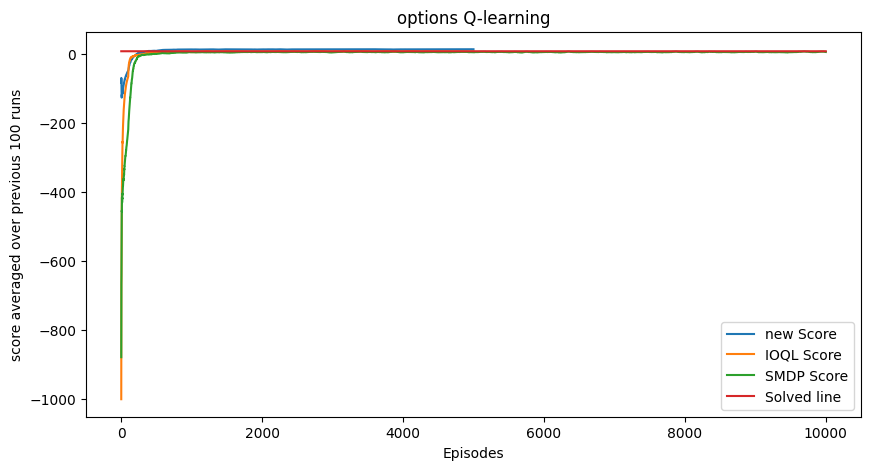

In [74]:
plt.figure(figsize = (10,5))

plt.plot(SMDP_sub_history,label = 'new Score')
plt.plot(IOQL_avg_history,label = 'IOQL Score')
plt.plot(SMDP_avg_history,label = 'SMDP Score')
plt.plot([8 for i in range(10000)],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('options Q-learning')
plt.legend()

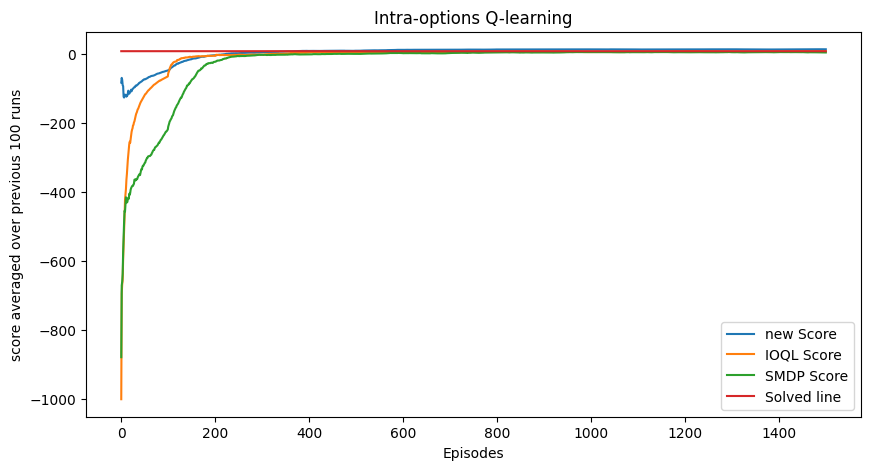

In [75]:
plt.figure(figsize = (10,5))

plt.plot(SMDP_sub_history[:1500],label = 'new Score')
plt.plot(IOQL_avg_history[:1500],label = 'IOQL Score')
plt.plot(SMDP_avg_history[:1500],label = 'SMDP Score')
plt.plot([8 for i in range(1500)],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Intra-options Q-learning')
plt.legend()